In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
print("pytorch ver . ",torch.__version__)
print("Is CUDA available?",torch.cuda.is_available())
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torch.utils.data as Data
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import xarray as xr
import os
os.environ['R_HOME'] = '/home/luhung3080/miniconda3/envs/chou/lib/R'
from rpy2.robjects import r, numpy2ri
numpy2ri.activate()
from rpy2.robjects.packages import importr
sinkr = importr('sinkr')
import Nio
print ("pynio ver . ",Nio.__version__)

/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pytorch ver .  1.11.0+cu113
Is CUDA available? True
pynio ver .  1.5.5


In [2]:
data=pd.read_csv('/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/data_final.csv')
data

,SITE_ID,date,FCST_TIME,TAU,pm25_cal,pm25_obs
0,EPA001,2020-02-24 08:00:00,2020-02-24 09:00:00,1,4.9510,10.0
1,EPA001,2020-02-24 08:00:00,2020-02-24 10:00:00,2,4.4674,13.0
2,EPA001,2020-02-24 08:00:00,2020-02-24 11:00:00,3,4.6159,11.0
3,EPA001,2020-02-24 08:00:00,2020-02-24 12:00:00,4,3.9937,11.0
4,EPA001,2020-02-24 08:00:00,2020-02-24 13:00:00,5,3.9602,9.0
...,...,...,...,...,...,...
3092755,EPA080,2021-10-30 08:00:00,2021-11-02 04:00:00,68,3.6190,4.0
3092756,EPA080,2021-10-30 08:00:00,2021-11-02 05:00:00,69,3.7908,7.0
3092757,EPA080,2021-10-30 08:00:00,2021-11-02 06:00:00,70,4.0454,7.0
3092758,EPA080,2021-10-30 08:00:00,2021-11-02 07:00:00,71,3.9015,4.0


In [3]:
###
#cal_PMf  
###
u=np.zeros([605,5112])
for i in range (0,605):
    a=np.array(data['pm25_cal'][5112*i:5112*i+5112])
    u[i]=a.T

###
#obs_PMf
###
v=np.zeros([605,5112])
for i in range (0,605):
    a=np.array(data['pm25_obs'][5112*i:5112*i+5112])
    v[i]=a.T

print(np.shape(u))
print(np.shape(v))

(605, 5112)
(605, 5112)


In [4]:
XRestruct_Fun=u
YRestruct_Fun=v
print(np.shape(XRestruct_Fun))
print(np.shape(YRestruct_Fun))

(605, 5112)
(605, 5112)


In [5]:
Xhat=XRestruct_Fun
Yhat=YRestruct_Fun
Xhat_train = np.zeros([544,5112])
Yhat_train = np.zeros([544,5112])
Xhat_test = np.zeros([61,5112])
Yhat_test = np.zeros([61,5112])
for i in range (0,544):
    for j in range (0,5112):
        Xhat_train[i][j] = Xhat[i][j]
        Yhat_train[i][j] = Yhat[i][j]
for i in range (544,605):
    for j in range (0,5112):
        Xhat_test[i-544][j] = Xhat[i][j]
        Yhat_test[i-544][j] = Yhat[i][j]

In [6]:
print('Xhat_train')
#print(Xhat_train)
print(np.shape(Xhat_train))
print('Yhat_train')
#print(Yhat_train)
print(np.shape(Yhat_train))
print('Xhat_test')
#print(Xhat_test)
print(np.shape(Xhat_test))
print('Yhat_test')
#print(Yhat_test)
print(np.shape(Yhat_test))

Xhat_train
(544, 5112)
Yhat_train
(544, 5112)
Xhat_test
(61, 5112)
Yhat_test
(61, 5112)


# GD

In [62]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [63]:
def model (x,b0,b1):
    y = b0 +  torch.mm(x , b1)
    return y

In [64]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

# beta0 = torch.randn(6816 , requires_grad = True)
# beta1 = torch.randn([8520 , 6816], requires_grad = True)

beta0 = torch.ones(5112 , requires_grad = True)
beta1 = torch.ones([5112,5112], requires_grad = True)

rate = 1e-3
optimizer = optim.Adam([beta0 , beta1], lr=rate)

epo = 2001
loss = nn.L1Loss()
train_error = np.zeros(epo)
test_error = np.zeros(epo)


for epoch in range (epo):
    yhats_train = model(features.float() , beta0 , beta1)
    train_loss = loss(targets.float() , yhats_train)
    train_error[epoch] = train_loss

    optimizer.zero_grad()
    train_loss.backward() 
    optimizer.step()    

    yhats_test = model(x_test.float(), beta0, beta1) 
#     for i in range (25):
#         for j in range (6816):
#             if y_test[i][j] == 0:
#                 yhats_test[i][j] = 0
    r = torch.abs(yhats_test - y_test)
    test_loss = torch.nanmean(r)
    # test_loss = loss(y_test , yhats_test)
    test_error[epoch] = test_loss

    if epoch <= 10 or epoch % 10 == 0:
        print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                    f" Testing loss {test_loss.item():.4f}")
        # print('\tBeta_0 : ' , beta0)
        # print('\tBeta_1 : ' , beta1)
    else :
        if epoch >= epo-10 :
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                        f" Testing loss {test_loss.item():.4f}")
            # print('\tBeta_0 : ' , beta0)
            # print('\tBeta_1 : ' , beta1)

Epoch 0, Training loss 68584.6484, Testing loss 77295.8799
Epoch 1, Training loss 68516.0469, Testing loss 77218.4953
Epoch 2, Training loss 68447.4453, Testing loss 77141.1109
Epoch 3, Training loss 68378.8516, Testing loss 77063.7223
Epoch 4, Training loss 68310.2500, Testing loss 76986.3368
Epoch 5, Training loss 68241.6484, Testing loss 76908.9519
Epoch 6, Training loss 68173.0469, Testing loss 76831.5668
Epoch 7, Training loss 68104.4453, Testing loss 76754.1837
Epoch 8, Training loss 68035.8516, Testing loss 76676.7990
Epoch 9, Training loss 67967.2578, Testing loss 76599.4155
Epoch 10, Training loss 67898.6562, Testing loss 76522.0293
Epoch 20, Training loss 67212.6719, Testing loss 75748.1743
Epoch 30, Training loss 66526.6797, Testing loss 74974.3245
Epoch 40, Training loss 65840.6953, Testing loss 74200.4737
Epoch 50, Training loss 65154.6992, Testing loss 73426.6188
Epoch 60, Training loss 64468.7070, Testing loss 72652.7662
Epoch 70, Training loss 63782.7188, Testing loss 7

Epoch 1300, Training loss 3.6943, Testing loss 6.0740
Epoch 1310, Training loss 3.6817, Testing loss 6.1370
Epoch 1320, Training loss 3.7046, Testing loss 6.1846
Epoch 1330, Training loss 3.7204, Testing loss 6.2181
Epoch 1340, Training loss 3.7074, Testing loss 6.2470
Epoch 1350, Training loss 3.7137, Testing loss 6.2770
Epoch 1360, Training loss 3.7443, Testing loss 6.3285
Epoch 1370, Training loss 3.7485, Testing loss 6.3972
Epoch 1380, Training loss 3.7589, Testing loss 6.4123
Epoch 1390, Training loss 3.7960, Testing loss 6.4388
Epoch 1400, Training loss 3.7942, Testing loss 6.5101
Epoch 1410, Training loss 3.8190, Testing loss 6.5273
Epoch 1420, Training loss 3.8464, Testing loss 6.5694
Epoch 1430, Training loss 3.8665, Testing loss 6.6044
Epoch 1440, Training loss 3.8719, Testing loss 6.6506
Epoch 1450, Training loss 3.9355, Testing loss 6.6625
Epoch 1460, Training loss 3.9189, Testing loss 6.7301
Epoch 1470, Training loss 3.9437, Testing loss 6.7388
Epoch 1480, Training loss 3.

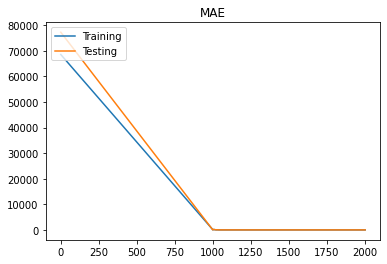

In [65]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,train_error, label = 'Training')
plt.plot(x,test_error, label ='Testing')
plt.legend(loc = 2)
plt.title('MAE')

plt.show()

In [66]:
print(np.min(test_error))

5.600592600958763


# LBFGS

In [7]:
x = Xhat_train
y = Yhat_train
xt = Xhat_test
yt = Yhat_test

In [8]:
def model (x,b0,b1):
    # y = b0 +  torch.matmul(x,b1)
    y = b0 + torch.mm(x, b1)
    return y

In [11]:
features = torch.from_numpy(x)
targets = torch.from_numpy(y)
x_test = torch.from_numpy(xt)
y_test = torch.from_numpy(yt)

beta0 = torch.ones(5112 , requires_grad = True)
beta1 = torch.ones([5112,5112] , requires_grad = True)


rate = 1e-2
optimizer = optim.LBFGS([beta0 , beta1] , lr = rate)

epo = 201
loss = nn.MSELoss()
train_error = np.zeros(epo)
test_error = np.zeros(epo)


for epoch in range (epo):  

    def closure():
        yhats_train = model(features.float() , beta0 , beta1)
        train_loss = loss(targets.float() , yhats_train)
        train_error[epoch] = train_loss
        optimizer.zero_grad()
        # if epoch == 0 :
        #     train_loss.backward(retain_graph=True) 
        # else :
        #     train_loss.backward()
        train_loss.backward(retain_graph=True) 
        return train_loss
    optimizer.step(closure)    

    yhats_test = model(x_test.float(), beta0, beta1) 
#     for i in range (25):
#         for j in range (6816):
#             if y_test[i][j] == 0:
#                 yhats_test[i][j] = 0
    r = torch.abs(yhats_test - y_test)
    test_loss = torch.nanmean(r)
    test_error[epoch] = test_loss

    if epoch <= 10 or epoch % 10 == 0:
        print(f"Epoch {epoch}, Training loss {train_error[epoch]:.4f},"
                    f" Testing loss {test_error[epoch]:.4f}")
        # print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
        #             f" Testing loss {test_loss:.4f}")
        # print('\tBeta_0 : ' , beta0.grad)
        # print('\tBeta_1 : ' , beta1.grad)
    else :
        if epoch >= epo-10 :
            print(f"Epoch {epoch}, Training loss {train_error[epoch]:.4f},"
                        f" Testing loss {test_error[epoch]:.4f}")
            # print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
            #             f" Testing loss {test_loss:.4f}")
            # print('\tBeta_0 : ' , beta0)
            # print('\tBeta_1 : ' , beta1)

Epoch 0, Training loss 5436126208.0000, Testing loss 77373.2646
Epoch 1, Training loss 47527829504.0000, Testing loss 232007.8190
Epoch 2, Training loss 31795210240.0000, Testing loss 189804.9293
Epoch 3, Training loss 21270343680.0000, Testing loss 155255.6386


KeyboardInterrupt: 

In [ ]:
fig1 = plt.figure(1)
x=np.linspace(1,epo,epo)
plt.plot(x,train_error, label = 'Training')
plt.plot(x,test_error, label ='Testing')
plt.legend(loc = 2)
plt.title('MAE')

plt.show()

In [ ]:
print(np.min(test_error))